In [1]:
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

titanic_data = sns.load_dataset('titanic')
titanic_data.info()
titanic_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


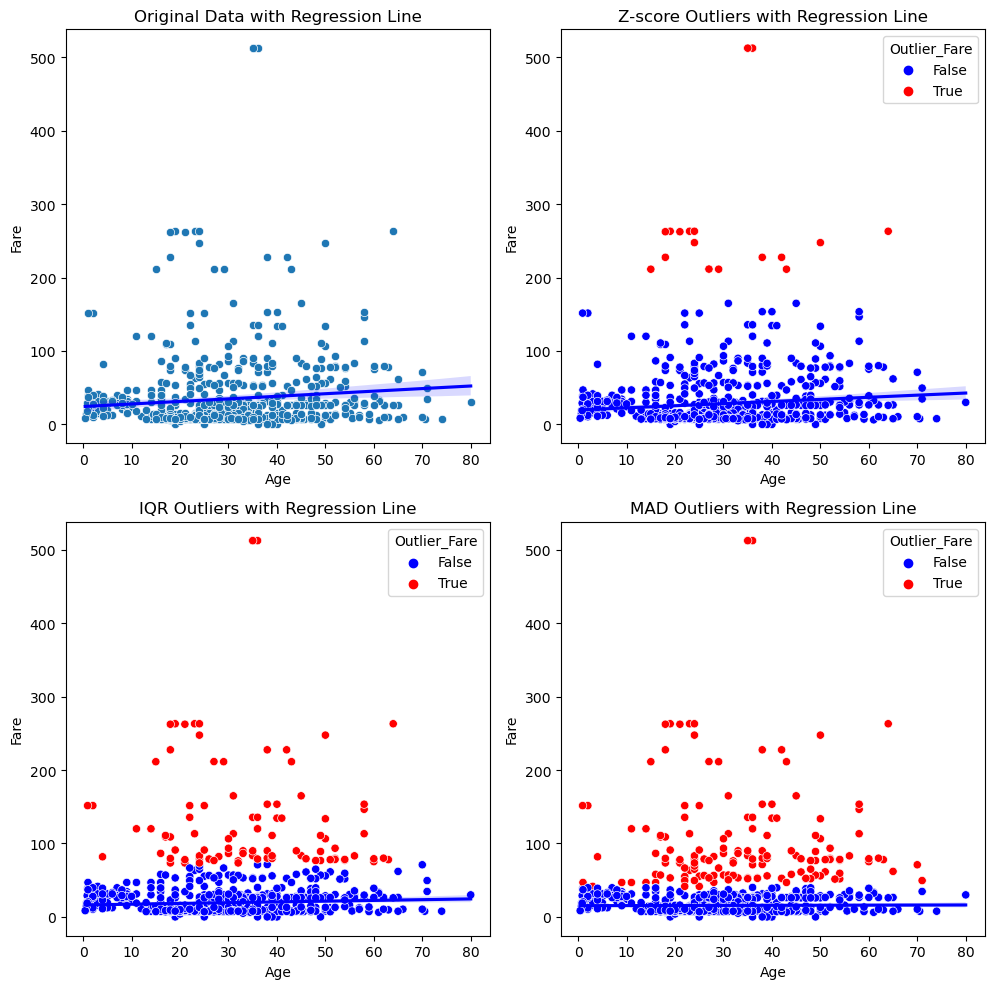

In [2]:
# 'fare'와 'age' 컬럼의 이상치 탐지
fare = titanic_data['fare'].dropna()
age = titanic_data['age'].dropna()

# 'fare'와 'age' 컬럼 모두 존재하는 데이터 필터링
titanic_filtered = titanic_data[['fare', 'age']].dropna()

# Z-점수 기반 이상치 탐지
z_scores_fare = np.abs(stats.zscore(titanic_filtered['fare']))
z_scores_age = np.abs(stats.zscore(titanic_filtered['age']))
threshold_z = 3
outliers_z_fare = titanic_filtered['fare'][z_scores_fare > threshold_z]
outliers_z_age = titanic_filtered['age'][z_scores_age > threshold_z]

# IQR 기반 이상치 탐지
Q1_fare = np.percentile(titanic_filtered['fare'], 25)
Q3_fare = np.percentile(titanic_filtered['fare'], 75)
IQR_fare = Q3_fare - Q1_fare
lower_bound_fare = Q1_fare - 1.5 * IQR_fare
upper_bound_fare = Q3_fare + 1.5 * IQR_fare
outliers_iqr_fare = titanic_filtered['fare'][(titanic_filtered['fare'] < lower_bound_fare) | (titanic_filtered['fare'] > upper_bound_fare)]

Q1_age = np.percentile(titanic_filtered['age'], 25)
Q3_age = np.percentile(titanic_filtered['age'], 75)
IQR_age = Q3_age - Q1_age
lower_bound_age = Q1_age - 1.5 * IQR_age
upper_bound_age = Q3_age + 1.5 * IQR_age
outliers_iqr_age = titanic_filtered['age'][(titanic_filtered['age'] < lower_bound_age) | (titanic_filtered['age'] > upper_bound_age)]

# MAD 기반 이상치 탐지
median_fare = np.median(titanic_filtered['fare'])
mad_fare = np.median(np.abs(titanic_filtered['fare'] - median_fare))
mad_scores_fare = np.abs(titanic_filtered['fare'] - median_fare) / mad_fare
threshold_mad = 3
outliers_mad_fare = titanic_filtered['fare'][mad_scores_fare > threshold_mad]

median_age = np.median(titanic_filtered['age'])
mad_age = np.median(np.abs(titanic_filtered['age'] - median_age))
mad_scores_age = np.abs(titanic_filtered['age'] - median_age) / mad_age
outliers_mad_age = titanic_filtered['age'][mad_scores_age > threshold_mad]

# 원본 데이터와 이상치 제거한 데이터프레임 생성
data_z = pd.DataFrame({
    'Fare': titanic_filtered['fare'],
    'Age': titanic_filtered['age'],
    'Outlier_Fare': z_scores_fare > threshold_z,
    'Outlier_Age': z_scores_age > threshold_z
})
data_iqr = pd.DataFrame({
    'Fare': titanic_filtered['fare'],
    'Age': titanic_filtered['age'],
    'Outlier_Fare': (titanic_filtered['fare'] < lower_bound_fare) | (titanic_filtered['fare'] > upper_bound_fare),
    'Outlier_Age': (titanic_filtered['age'] < lower_bound_age) | (titanic_filtered['age'] > upper_bound_age)
})
data_mad = pd.DataFrame({
    'Fare': titanic_filtered['fare'],
    'Age': titanic_filtered['age'],
    'Outlier_Fare': mad_scores_fare > threshold_mad,
    'Outlier_Age': mad_scores_age > threshold_mad
})

# 시각화
plt.figure(figsize=(15, 10))

# 원본 데이터에 대한 회귀선
plt.subplot(2, 3, 1)
sns.scatterplot(x=titanic_filtered['age'], y=titanic_filtered['fare'], marker='o')
sns.regplot(x=titanic_filtered['age'], y=titanic_filtered['fare'], scatter=False, color='blue')
plt.title('Original Data with Regression Line')
plt.xlabel('Age')
plt.ylabel('Fare')

# Z-score based outliers
plt.subplot(2, 3, 2)
sns.scatterplot(data=data_z, x='Age', y='Fare', hue='Outlier_Fare', palette={False: 'blue', True: 'red'}, marker='o')
sns.regplot(data=data_z[data_z['Outlier_Fare'] == False], x='Age', y='Fare', scatter=False, color='blue')
plt.title('Z-score Outliers with Regression Line')
plt.xlabel('Age')
plt.ylabel('Fare')

# IQR based outliers
plt.subplot(2, 3, 4)
sns.scatterplot(data=data_iqr, x='Age', y='Fare', hue='Outlier_Fare', palette={False: 'blue', True: 'red'}, marker='o')
sns.regplot(data=data_iqr[data_iqr['Outlier_Fare'] == False], x='Age', y='Fare', scatter=False, color='blue')
plt.title('IQR Outliers with Regression Line')
plt.xlabel('Age')
plt.ylabel('Fare')

# MAD based outliers
plt.subplot(2, 3, 5)
sns.scatterplot(data=data_mad, x='Age', y='Fare', hue='Outlier_Fare', palette={False: 'blue', True: 'red'}, marker='o')
sns.regplot(data=data_mad[data_mad['Outlier_Fare'] == False], x='Age', y='Fare', scatter=False, color='blue')
plt.title('MAD Outliers with Regression Line')
plt.xlabel('Age')
plt.ylabel('Fare')

plt.tight_layout()
plt.show()

## 스케일링 비교

In [3]:
#사이킷런 패키지에서 불러오기
from sklearn.preprocessing import StandardScaler
import numpy as np

#예제 데이터
data =np.array([[1,2,3],[4,5,6],[7,8,9]])

#표준화 
scaler = StandardScaler()
#fit_trasform 학습
scaled_data=scaler.fit_transform(data)
print(scaled_data) #표준화된 스케일링 데이터

[[-1.22474487 -1.22474487 -1.22474487]
 [ 0.          0.          0.        ]
 [ 1.22474487  1.22474487  1.22474487]]


In [4]:
#정규화
##minmax
from sklearn.preprocessing import MinMaxScaler

#예제 데이터
data =np.array([[1,2,3],[4,5,6],[7,8,9]])
scaler =MinMaxScaler()
normalized_data=scaler.fit_transform(data)
print(normalized_data)

[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]


In [5]:
##최대 절대값 스케일링 abs
from sklearn.preprocessing import MaxAbsScaler

data =np.array([[1,2,3],[4,5,6],[7,8,9]])
scaler = MaxAbsScaler()
max_abs_scaled_data =scaler.fit_transform(data)
print(max_abs_scaled_data)

[[0.14285714 0.25       0.33333333]
 [0.57142857 0.625      0.66666667]
 [1.         1.         1.        ]]


In [6]:
## Robust 스케일링
from sklearn.preprocessing import RobustScaler

data_ol =np.array([[1,2,3],[4,5,100],[7,8,9]])
data =np.array([[1,2,3],[4,5,6],[7,8,9]])

scaler = RobustScaler()
robust_scaled_data =scaler.fit_transform(data)
print(robust_scaled_data)


robust_scaled_data_ol =scaler.fit_transform(data_ol)
print(robust_scaled_data_ol)

[[-1. -1. -1.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]]
[[-1.         -1.         -0.12371134]
 [ 0.          0.          1.87628866]
 [ 1.          1.          0.        ]]


In [7]:
#QuantileTransformer

from sklearn.preprocessing import QuantileTransformer

data =np.array([[1,2,3],[4,5,6],[7,8,9]])

## 균등분포
scaler = QuantileTransformer(output_distribution = 'uniform')
quantile_scaled_data_uniform=scaler.fit_transform(data)
print(quantile_scaled_data_uniform)

## 정규분포
scaler = QuantileTransformer(output_distribution = 'normal')
quantile_scaled_data_normal=scaler.fit_transform(data)
print(quantile_scaled_data_normal)

[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]
[[-5.19933758 -5.19933758 -5.19933758]
 [ 0.          0.          0.        ]
 [ 5.19933758  5.19933758  5.19933758]]


C:\Users\pitap\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\pitap\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  warnings.warn(


In [8]:
#Powertransformer
from sklearn.preprocessing import PowerTransformer

data =np.array([[1,2,3],[4,5,6],[7,8,9]])
# Yeo-Johnson - 데이터의 음수도 가능하다.
scaler = PowerTransformer(method='yeo-johnson')
power_scaled_data_yeo = scaler.fit_transform(data)
print(power_scaled_data_yeo)

# Box-Cox - 데이터 양수만 가능
scaler = PowerTransformer(method='box-cox')
power_scaled_data_bc = scaler.fit_transform(data)
print(power_scaled_data_bc)



[[-1.27811626 -1.26755013 -1.26070573]
 [ 0.11483096  0.09064754  0.07540621]
 [ 1.16328529  1.17690258  1.18529952]]
[[-1.2976387  -1.27811626 -1.26755013]
 [ 0.16188984  0.11483097  0.09064754]
 [ 1.13574886  1.16328529  1.17690259]]


In [9]:
titanic = sns.load_dataset('titanic')

## 결측값 제거 
titanic=titanic.dropna(subset=['age','fare'])

## 스케일링 전의 데이터

data=titanic[['age','fare']]

## 비교할 시각화 함수

def plot_comparison(original_data, scaled_data, title):
    fig,(ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    sns.histplot(original_data, kde=True, ax=ax1)
    ax1.set_title('Original' + title)
    sns.histplot(scaled_data, kde=True, ax=ax2)
    ax2.set_title('Scaled' + title)
    plt.show()

C:\Users\pitap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pitap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


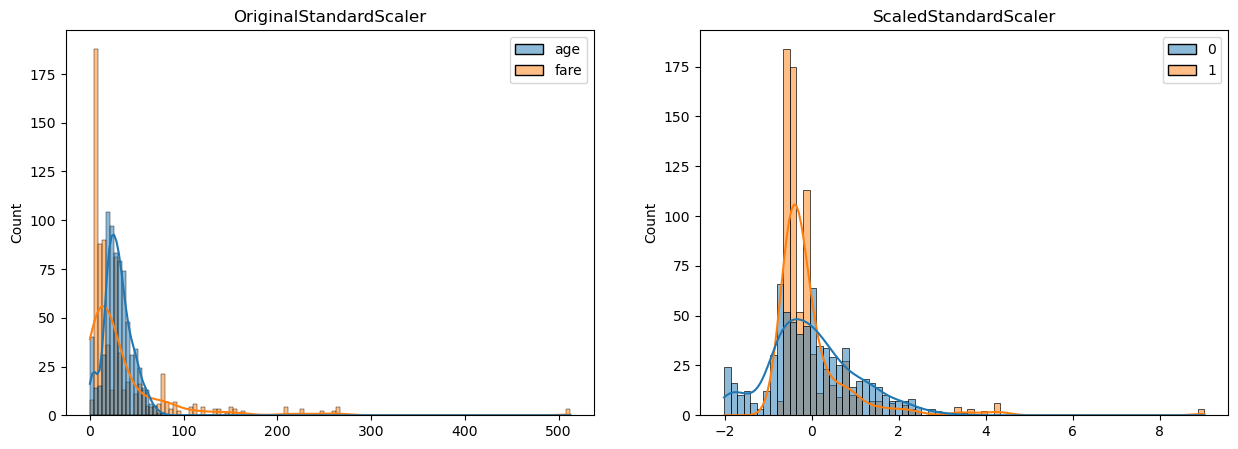

In [10]:
#표준화 
scaler = StandardScaler()
#fit_trasform 학습
scaled_data=scaler.fit_transform(data)
plot_comparison(data, scaled_data, 'StandardScaler')

C:\Users\pitap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pitap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


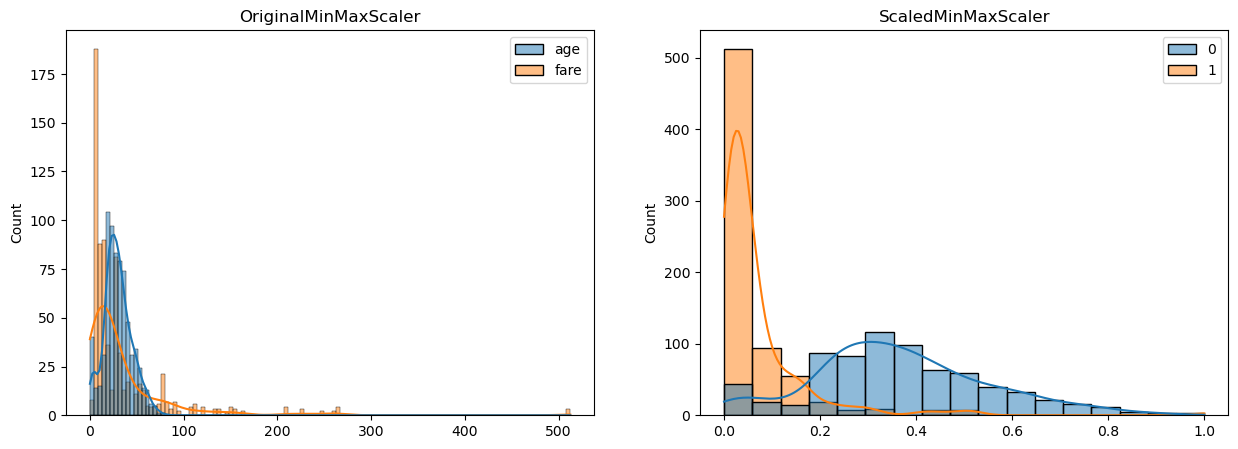

In [11]:
#minmax
scaler =MinMaxScaler()
normalized_data=scaler.fit_transform(data)
plot_comparison(data, normalized_data, 'MinMaxScaler')

C:\Users\pitap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pitap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


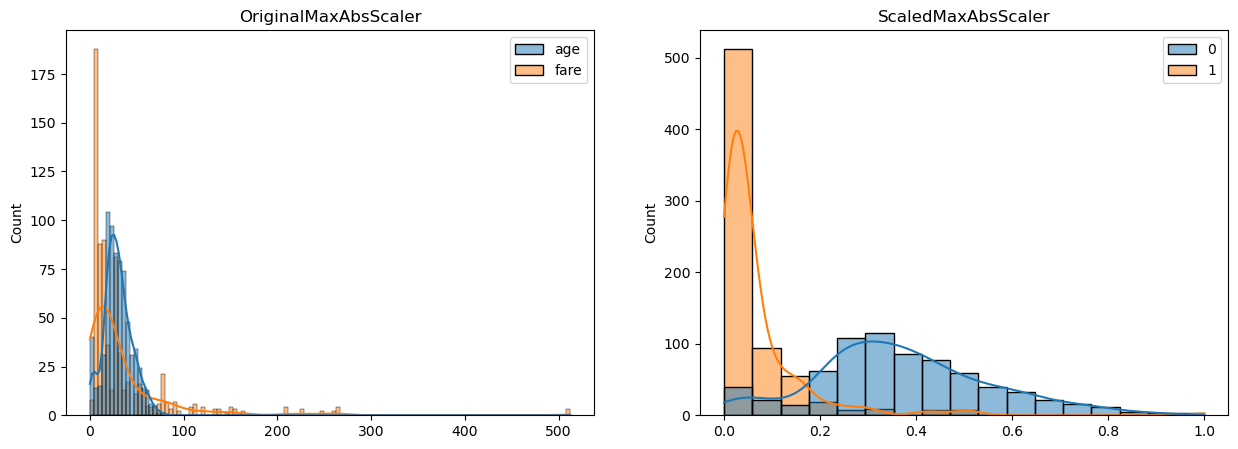

In [12]:
#MaxAbsScaler
scaler = MaxAbsScaler()
max_abs_scaled_data =scaler.fit_transform(data)

plot_comparison(data, max_abs_scaled_data, 'MaxAbsScaler')

C:\Users\pitap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pitap\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


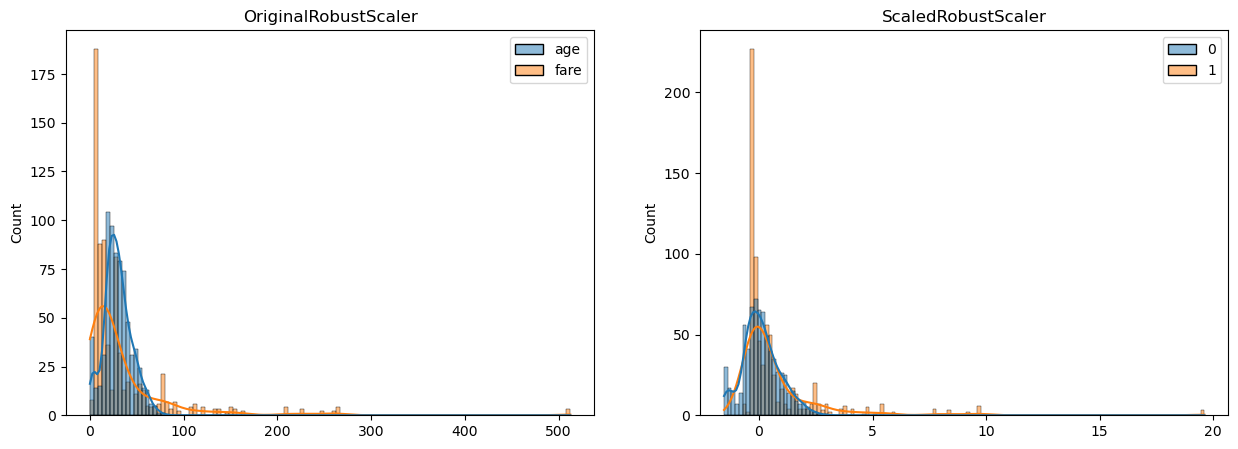

In [13]:
#RobustScaler
scaler = RobustScaler()
robust_scaled_data =scaler.fit_transform(data)
plot_comparison(data, robust_scaled_data, 'RobustScaler')

In [ ]:
## 균등분포
scaler = QuantileTransformer(output_distribution = 'uniform')
quantile_scaled_data_uniform=scaler.fit_transform(data)
plot_comparison(data, quantile_scaled_data_uniform, 'uniform')

## 정규분포
scaler = QuantileTransformer(output_distribution = 'normal')
quantile_scaled_data_normal=scaler.fit_transform(data)
plot_comparison(data, quantile_scaled_data_normal, 'normal')

In [ ]:
# Power Transformer (Yeo-Johnson)
scaler = PowerTransformer(method='yeo-johnson')
power_scaled_data_yeo = scaler.fit_transform(data)

# 시각화
plot_comparison(data, power_scaled_data_yeo, 'Power Scaling (Yeo-Johnson)')

# Power Transformer (Box-Cox) - 데이터는 양수만 가능
scaler = PowerTransformer(method='box-cox')
power_scaled_data_boxcox = scaler.fit_transform(data + 1)  # Box-Cox 변환을 위해 데이터에 1을 더함

# 시각화
plot_comparison(data, power_scaled_data_boxcox, 'Power Scaling (Box-Cox)')
